In [141]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, TimesNet

from neuralforecast.losses.numpy import mae, mse, mape

In [83]:
pd.set_option('display.max_rows', None)

In [84]:
plt.rcParams["figure.figsize"] = (9,6)

In [85]:
file_name = 'data/Single_sample.csv'

## Read data 

In [86]:
df = pd.read_csv(file_name, header=0, names=['ds', 'y'])
df.head()

,ds,y
0,2015-04-09 23:00:00,30400.0
1,2015-04-10 00:00:00,27148.0
2,2015-04-10 01:00:00,25257.0
3,2015-04-10 02:00:00,24309.0
4,2015-04-10 03:00:00,23802.0


In [87]:
df.describe()

,y
count,61104.000000
mean,32756.927533
std,7517.551463
min,15334.000000
25%,26299.000000
50%,32172.000000
75%,39161.000000
max,55157.000000


**Add a new column 'unique_id', because NeuralForecast expects it.**

In [88]:
df['unique_id'] = 'Value'
df.head()

,ds,y,unique_id
0,2015-04-09 23:00:00,30400.0,Value
1,2015-04-10 00:00:00,27148.0,Value
2,2015-04-10 01:00:00,25257.0,Value
3,2015-04-10 02:00:00,24309.0,Value
4,2015-04-10 03:00:00,23802.0,Value


**Some dates are in a different format so, we convert all dates to a single format.**

In [89]:
df['ds'] = df['ds'].apply(lambda x: pd.to_datetime(x).strftime('%Y-%m-%d %H:%M:%S'))
df['ds'] = pd.to_datetime(df['ds'])
print(df.head())

                   ds        y unique_id
0 2015-04-09 23:00:00  30400.0     Value
1 2015-04-10 00:00:00  27148.0     Value
2 2015-04-10 01:00:00  25257.0     Value
3 2015-04-10 02:00:00  24309.0     Value
4 2015-04-10 03:00:00  23802.0     Value


In [90]:
df.dtypes

ds           datetime64[ns]
y                   float64
unique_id            object
dtype: object

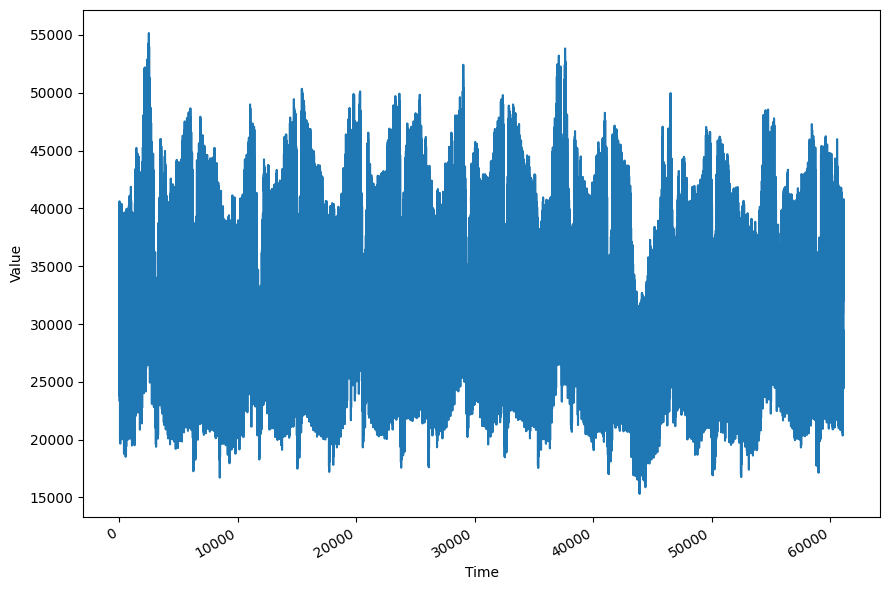

In [91]:
fig, ax = plt.subplots()

ax.plot(df['y'])
ax.set_xlabel('Time')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

In [92]:
# Define a date range for filtering
start_date = '2022-02-14 00:00:00'
end_date = '2022-02-16 23:00:00'

# Create a boolean condition for filtering
condition = (df['ds'] >= start_date) & (df['ds'] <= end_date)
# condition = (df['ds'] >= start_date)

# Apply the boolean condition to filter the DataFrame
filtered_df = df[condition]

**Visualize the missing values**

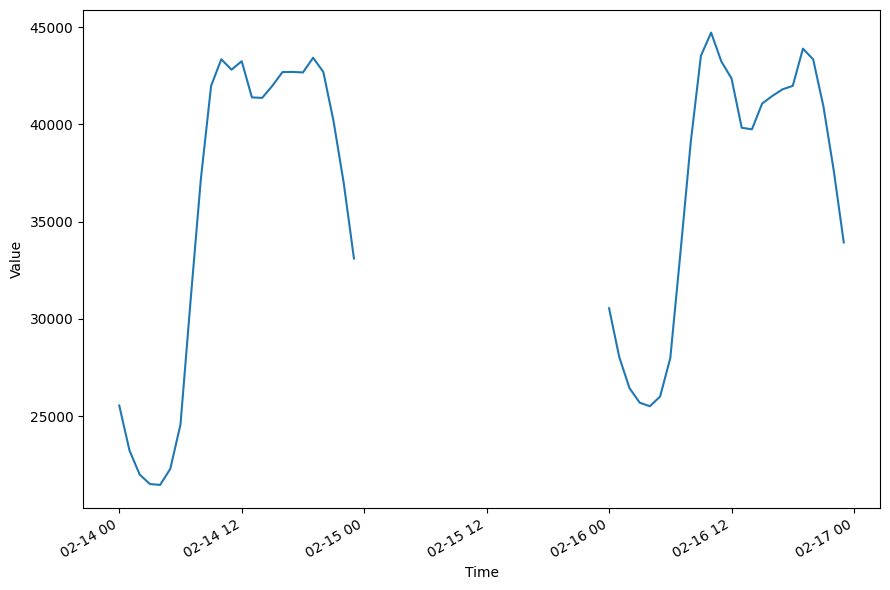

In [93]:
fig, ax = plt.subplots()

ax.plot(filtered_df['ds'], filtered_df['y'])
ax.set_xlabel('Time')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

**Now visualize the values from the same period, but from a different month**

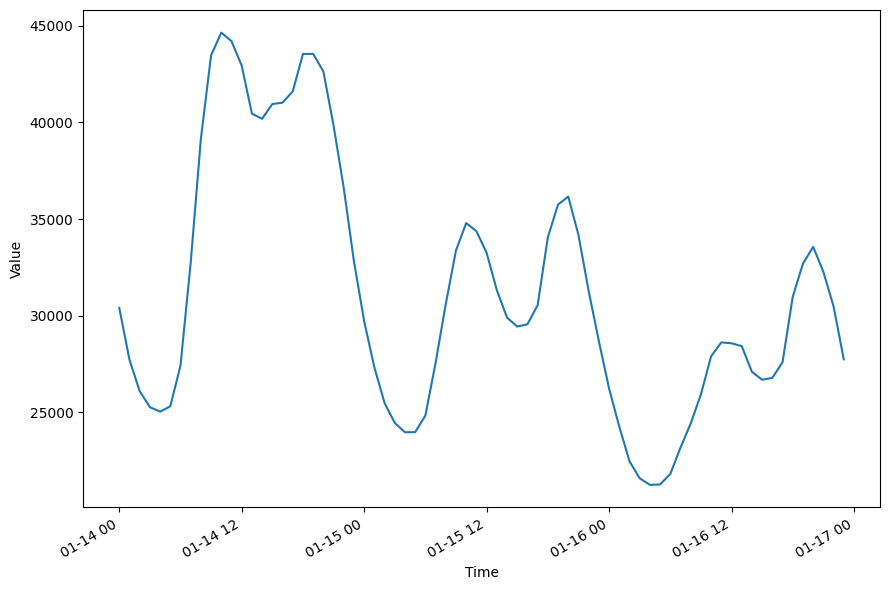

In [94]:
start_date = '2022-01-14 00:00:00'
end_date = '2022-01-16 23:00:00'

condition_2 = (df['ds'] >= start_date) & (df['ds'] <= end_date)

filtered_df = df[condition_2]

fig, ax = plt.subplots()

ax.plot(filtered_df['ds'], filtered_df['y'])
ax.set_xlabel('Time')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

**Fill the missing values with the mean value**

In [95]:
df['y'].fillna(df['y'].mean(), inplace=True)
df.head()

,ds,y,unique_id
0,2015-04-09 23:00:00,30400.0,Value
1,2015-04-10 00:00:00,27148.0,Value
2,2015-04-10 01:00:00,25257.0,Value
3,2015-04-10 02:00:00,24309.0,Value
4,2015-04-10 03:00:00,23802.0,Value


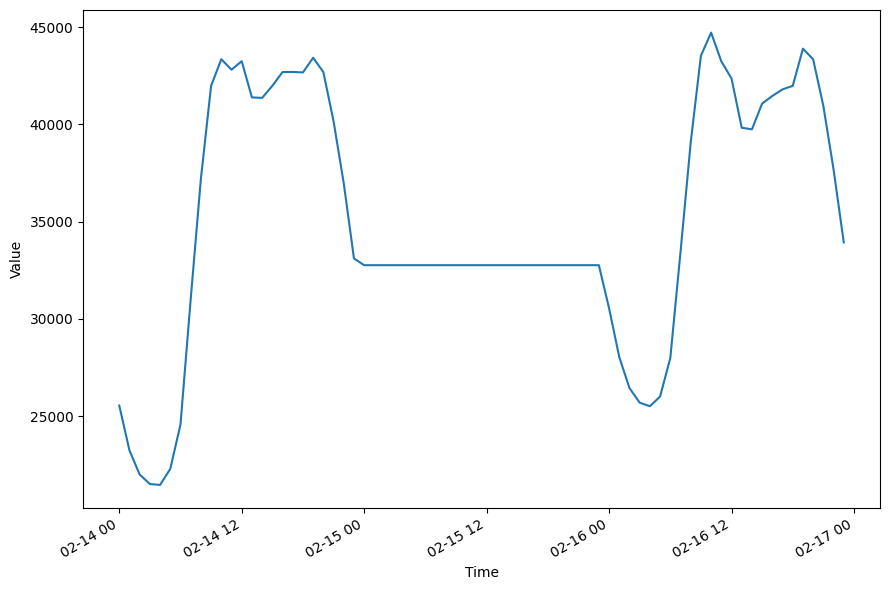

In [96]:
# Apply the boolean condition to filter the DataFrame
filtered_df_clean = df[condition]

fig, ax = plt.subplots()

ax.plot(filtered_df_clean['ds'], filtered_df_clean['y'])
ax.set_xlabel('Time')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

**We remove the last 48 records since, there are some null values in them. Doing forecast on these values will be difficult**

In [97]:
df = df[:-48]
df.tail()

,ds,y,unique_id
61099,2022-03-29 18:00:00,35546.0,Value
61100,2022-03-29 19:00:00,37886.0,Value
61101,2022-03-29 20:00:00,38470.0,Value
61102,2022-03-29 21:00:00,35654.0,Value
61103,2022-03-29 22:00:00,32427.0,Value


In [98]:
df_with_index = df.set_index('ds')

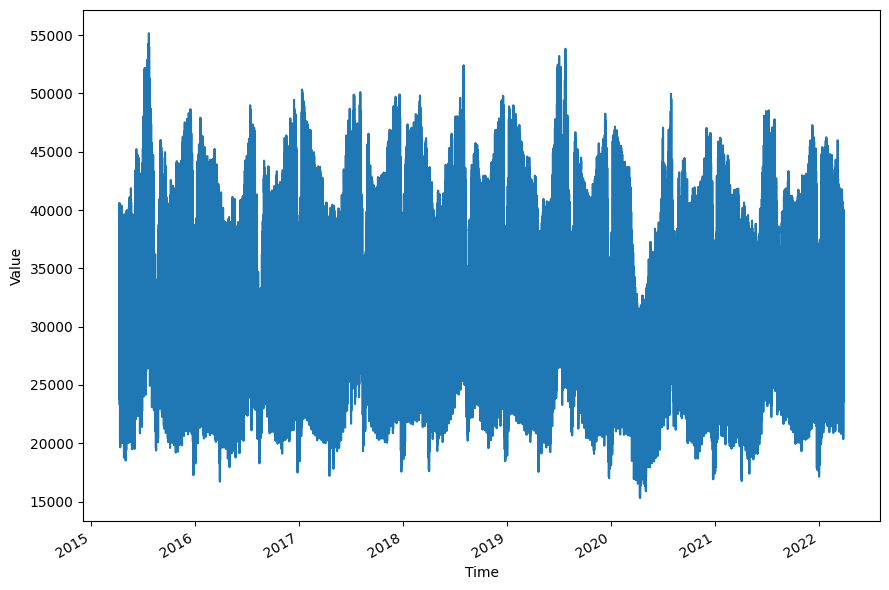

In [99]:
## visualize the series after replacing nulls
fig, ax = plt.subplots()

ax.plot(df_with_index['y'])
ax.set_xlabel('Time')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

**Visualize the Yearly data**


years info: 
                2015          2016          2017          2018          2019  \
count   6385.000000   8784.000000   8760.000000   8760.000000   8760.000000   
mean   32844.738606  32247.294057  33271.216096  33932.735502  33578.869863   
std     7568.715062   7288.162103   7567.308567   7555.481177   7731.109284   
min    17268.000000  16716.000000  17212.000000  17610.000000  17014.000000   
25%    26292.000000  25897.500000  26631.750000  27324.000000  26831.500000   
50%    32368.000000  31611.000000  32862.000000  33320.000000  33178.000000   
75%    38799.000000  38674.500000  39507.500000  40532.500000  39946.500000   
max    55157.000000  49441.000000  50333.000000  52412.000000  53824.000000   

               2020          2021          2022  
count   8784.000000   8760.000000   2111.000000  
mean   31102.003188  32303.484932  32941.005334  
std     7449.641195   7138.819262   7303.324265  
min    15334.000000  16767.000000  17140.000000  
25%    25157.750000  26

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

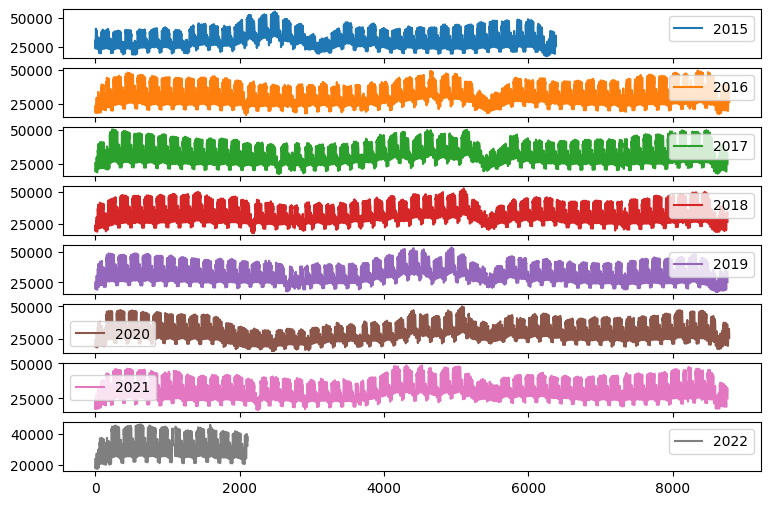

In [100]:
# df_with_index = df.set_index('ds')

groups = df_with_index.groupby(pd.Grouper(freq='A'))
# years = pd.DataFrame(columns=df['ds'].dt.year.unique())
years = pd.DataFrame()
for name, group in groups:
    # print('Name: {}, Shape: {}'.format(name.year, group.shape))
    year = pd.DataFrame({name.year:group['y'].tolist()})
    years = pd.concat([years,year], ignore_index=True, axis=1)

years.columns = df['ds'].dt.year.unique()
print ('\nyears info: \n', years.describe())
years.plot(subplots=True, legend=True)

**Visualize the Monthly data for Year 2020**


months info: 
                  1             2             3             4             5   \
count    744.000000    696.000000    744.000000    720.000000    744.000000   
mean   33748.069892  33553.827586  28529.662634  24218.909722  26999.739247   
std     8340.330778   7266.343632   6864.285056   4495.981098   5552.662803   
min    18123.000000  20721.000000  16848.000000  15334.000000  15888.000000   
25%    26182.750000  26743.250000  23015.750000  20287.000000  22440.750000   
50%    33185.500000  33116.500000  27594.000000  24295.000000  26029.000000   
75%    42152.500000  40773.250000  32452.500000  27850.500000  32680.250000   
max    47153.000000  45511.000000  43700.000000  32816.000000  37276.000000   

                 6             7             8             9             10  \
count    720.000000    744.000000    744.000000    720.000000    744.000000   
mean   29872.444444  35286.150538  31920.639785  33310.881944  31689.608871   
std     6372.896836   7388.479245  

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

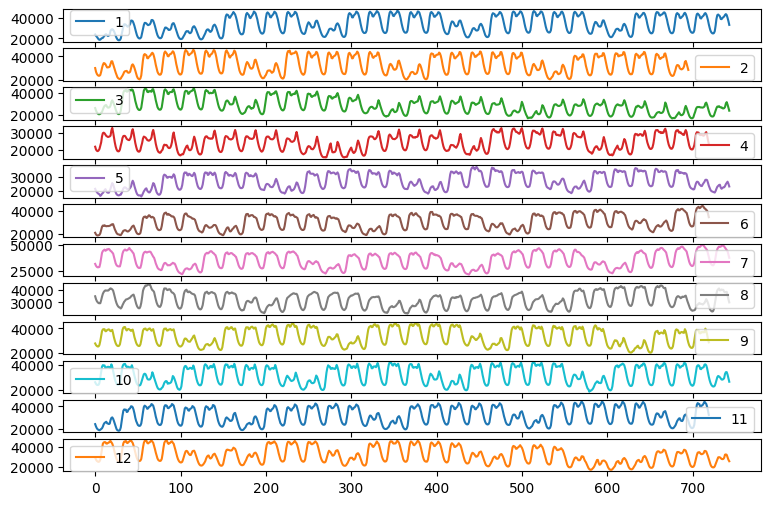

In [101]:
groups = df_with_index.loc[f'{2020}'].groupby(pd.Grouper(freq='M'))
# groups = df_with_index.groupby(pd.Grouper(freq='M'))
# years = pd.DataFrame(columns=df['ds'].dt.year.unique())
months = pd.DataFrame()
for name, group in groups:
    # print('Name: {}, Shape: {}'.format(name.month, group.shape))
    month = pd.DataFrame({name.month:group['y'].tolist()})
    months = pd.concat([months,month], ignore_index=True, axis=1)

months.columns = sorted(df['ds'].dt.month.unique())
print ('\nmonths info: \n', months.describe())
months.plot(subplots=True, legend=True)

**We can NOT see a monthly period!!!**

## Model 

In [116]:
horizon = 96
# horizon = 24
# train_steps = 50
train_steps = 200
window_factor = 2
# window_factor = 4

models = [NHITS(h=horizon,
               input_size=window_factor*horizon,
               max_steps=train_steps),
         NBEATS(h=horizon,
               input_size=window_factor*horizon,
               max_steps=train_steps),
         TimesNet(h=horizon,
                 input_size=window_factor*horizon,
                 max_steps=train_steps)]

Seed set to 1
Seed set to 1
Seed set to 1


In [117]:
nf = NeuralForecast(models=models, freq='H')

In [118]:
preds_df = nf.cross_validation(df=df, step_size=horizon, n_windows=2)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.60it/s]


In [119]:
preds_df.head()

,unique_id,ds,cutoff,NHITS,NBEATS,TimesNet,y
0,Value,2022-03-21 23:00:00,2022-03-21 22:00:00,32357.675781,32043.921875,31765.914062,32040.0
1,Value,2022-03-22 00:00:00,2022-03-21 22:00:00,29065.939453,29432.591797,28627.394531,28984.0
2,Value,2022-03-22 01:00:00,2022-03-21 22:00:00,26548.326172,26517.718750,26240.566406,26517.0
3,Value,2022-03-22 02:00:00,2022-03-21 22:00:00,25183.462891,25190.701172,24376.070312,25158.0
4,Value,2022-03-22 03:00:00,2022-03-21 22:00:00,24325.937500,24299.312500,23597.078125,24427.0


In [120]:
preds_df.dtypes

unique_id           object
ds           datetime64[s]
cutoff       datetime64[s]
NHITS              float32
NBEATS             float32
TimesNet           float32
y                  float64
dtype: object

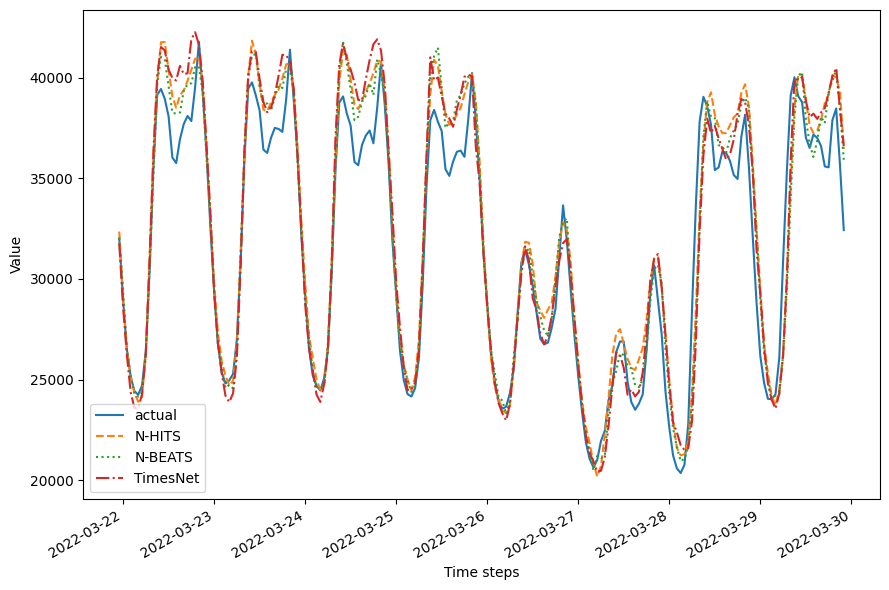

In [121]:
preds_df_with_index = preds_df.set_index('ds')

fig, ax = plt.subplots()

ax.plot(preds_df_with_index['y'], label='actual')
ax.plot(preds_df_with_index['NHITS'], label='N-HITS', ls='--')
ax.plot(preds_df_with_index['NBEATS'], label='N-BEATS', ls=':')
ax.plot(preds_df_with_index['TimesNet'], label='TimesNet', ls='-.')

ax.legend(loc='best')
ax.set_xlabel('Time steps')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

In [142]:
data = {'N-HiTS': [mae(preds_df['NHITS'], preds_df['y']), mse(preds_df['NHITS'], preds_df['y']), mape(preds_df['NHITS'], preds_df['y'])],
       'N-BEATS': [mae(preds_df['NBEATS'], preds_df['y']), mse(preds_df['NBEATS'], preds_df['y']), mape(preds_df['NBEATS'], preds_df['y'])],
       'TimesNet': [mae(preds_df['TimesNet'], preds_df['y']), mse(preds_df['TimesNet'], preds_df['y']), mape(preds_df['TimesNet'], preds_df['y'])]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse', 'mape']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,TimesNet
mae,1399.744080,1217.269592,1420.568817
mse,3250642.940902,2860607.076063,3740884.111303
mape,0.041952,0.036470,0.042414


In [131]:
metrics_df

,N-HiTS,N-BEATS,TimesNet
mae,1.399744e+03,1.217270e+03,1.420569e+03
mse,3.250643e+06,2.860607e+06,3.740884e+06


We add a is_weekend column to our data to check if the weekends show a particular trend

In [132]:
df['is_weekend'] = (df['ds'].dt.weekday >= 5).astype(int)
df.describe()

,ds,y,is_weekend
count,61104,61104.000000,61104.000000
mean,2018-10-03 22:29:59.999999744,32756.421662,0.285939
min,2015-04-09 23:00:00,15334.000000,0.000000
25%,2017-01-05 10:45:00,26301.000000,0.000000
50%,2018-10-03 22:30:00,32178.000000,0.000000
75%,2020-07-01 10:15:00,39161.000000,1.000000
max,2022-03-29 22:00:00,55157.000000,1.000000
std,NaN,7516.646106,0.451864


In [133]:
df.head()

,ds,y,unique_id,is_weekend
0,2015-04-09 23:00:00,30400.0,Value,0
1,2015-04-10 00:00:00,27148.0,Value,0
2,2015-04-10 01:00:00,25257.0,Value,0
3,2015-04-10 02:00:00,24309.0,Value,0
4,2015-04-10 03:00:00,23802.0,Value,0


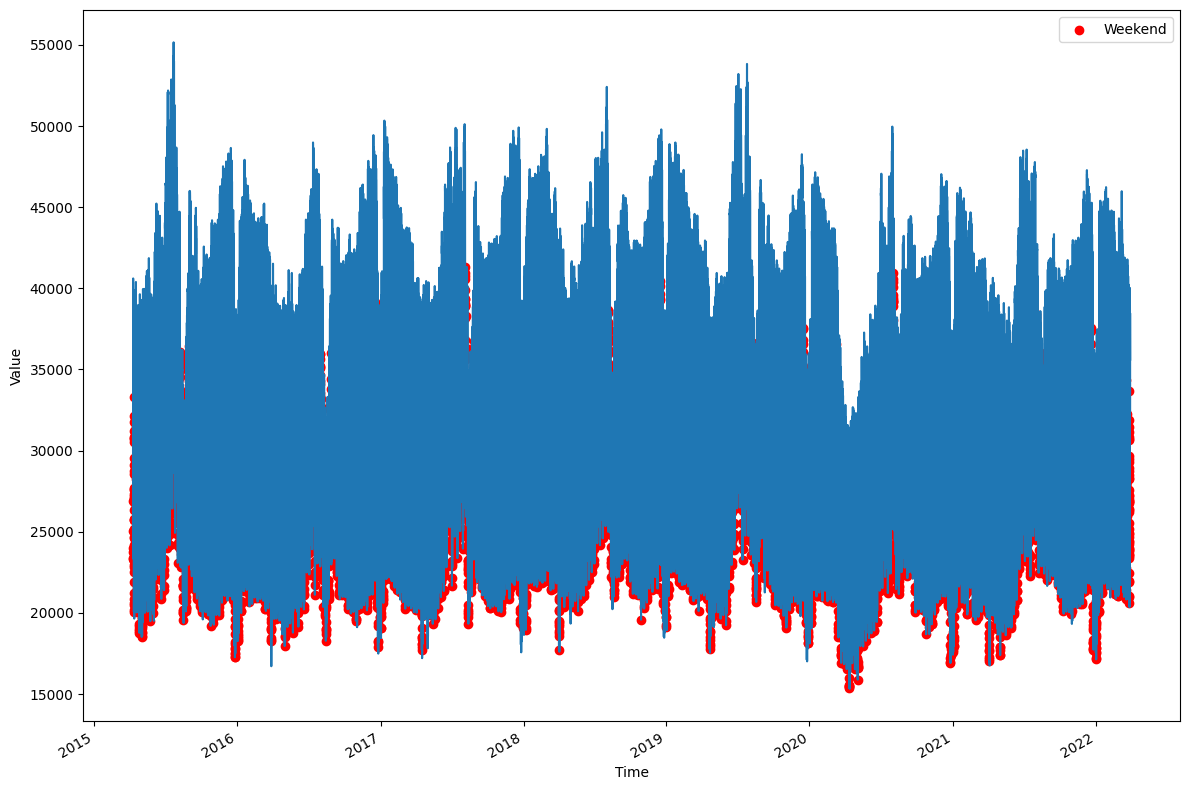

In [135]:
weekend_dates = df[df['is_weekend'] == 1]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df['ds'], df['y'])
ax.scatter(weekend_dates['ds'], weekend_dates['y'], marker='o', color='red', label='Weekend')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

In [139]:
df_with_index_new = df.set_index('ds')
df_with_index_new.head()

,y,unique_id,is_weekend
ds,,,
2015-04-09 23:00:00,30400.0,Value,0
2015-04-10 00:00:00,27148.0,Value,0
2015-04-10 01:00:00,25257.0,Value,0
2015-04-10 02:00:00,24309.0,Value,0
2015-04-10 03:00:00,23802.0,Value,0



months head: 
         1        2        3        4        5        6        7        8   \
0  23876.0  30205.0  26232.0  21684.0  21427.0  20846.0  31612.0  34738.0   
1  22510.0  27078.0  23918.0  19988.0  19908.0  19376.0  29679.0  32385.0   
2  21542.0  25267.0  22280.0  19286.0  19068.0  18638.0  28693.0  30866.0   
3  20270.0  24268.0  21294.0  19076.0  18263.0  18448.0  28265.0  30027.0   
4  19148.0  23761.0  20672.0  19462.0  17841.0  18696.0  28366.0  29387.0   

        9        10       11       12  
0  27635.0  26150.0  24459.0  29450.0  
1  26231.0  24809.0  22344.0  27194.0  
2  25468.0  24049.0  20764.0  25946.0  
3  25084.0  23973.0  19894.0  25305.0  
4  25181.0  24145.0  19423.0  24962.0  


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

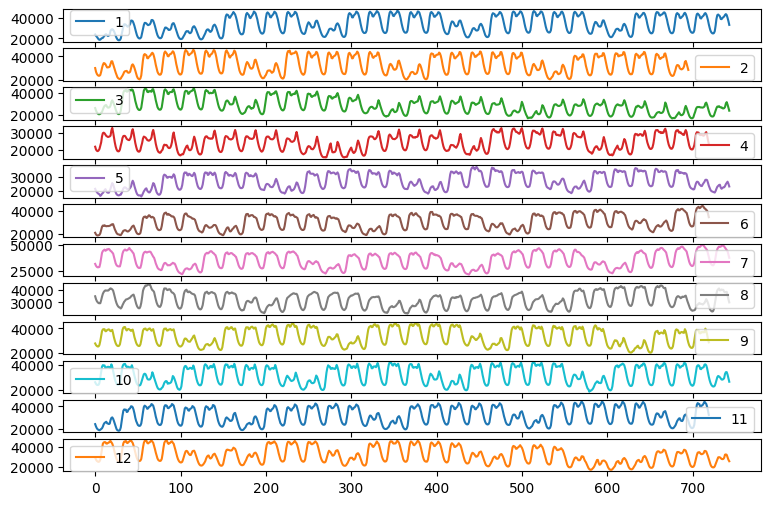

In [140]:
groups_months = df_with_index_new.loc[f'{2020}'].groupby(pd.Grouper(freq='M'))
# groups = df_with_index.groupby(pd.Grouper(freq='M'))
# years = pd.DataFrame(columns=df['ds'].dt.year.unique())
months = pd.DataFrame()
for name, group in groups_months:
    # print('Name: {}, Shape: {}'.format(name.month, group.shape))
    month = pd.DataFrame({name.month:group['y'].tolist()})
    months = pd.concat([months,month], ignore_index=True, axis=1)

months.columns = sorted(df['ds'].dt.month.unique())
print ('\nmonths head: \n', months.head())
months.plot(subplots=True, legend=True)
months.plot.scatter(y='is_weekend', color='red', label='Scatter Plot 1', ax=ax)
